# Imports et chargement des données

In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                     "figure.figsize":[10,8], "savefig.bbox":"tight"})


In [3]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [4]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [5]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

In [6]:
def conf_matrix(y_true, y_pred, seuil, verbose=True): 
    """
    input :
    y_true : vecteur de la classification attendue (classification binaire)
    y_pred : score prédit
    seuil : seuil pour décider qu'un score est positif
    
    output :
    pour différents seuils :
    tn : vecteur des vrais négatifs
    fp : vecteur des faux positifs
    fn : vecteur des faux négatifs
    tp : vecteur des vrais positifs
    fpr : taux de faux positifs
    fnr : taux de faux négatifs
    precision
    recall
    
    """
#     fpr, tpr, th = roc_curve(y_true, y_pred)
    tp = []
    tn = []
    fn = []
    fp = []
    scores = []
    c_pred = (y_pred >= seuil).astype(int) #class prediction
    tp = ((c_pred==1) & (y_true==1)).sum()
    tn = ((c_pred==0) & (y_true==0)).sum()
    fn = ((c_pred==0) & (y_true==1)).sum()
    fp = ((c_pred==1) & (y_true==0)).sum()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    if verbose :
        print("tp : ", tp)
        print("tn : ", tn)
        print("fp : ", fp)
        print("fn : ", fn)
        print(f"fpr = {fpr*100:.2f}%")
        print(f"fnr = {fnr*100:.2f}%")
        print(f"precision = {precision*100:.2f}%")
        print(f"recall = {recall*100:.2f}%")


    return tn, fp, fn, tp, fpr, fnr, precision, recall
    


In [7]:
def to_labels(preds, threshold):
    return (preds >= threshold).astype(int)

In [8]:
def matthews_eval(preds, train_data):
#     seuil = 0.5
    y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = matthews_corrcoef(y_true, c_pred)
    thresholds = np.arange(0,1, 0.01)
    scores = [matthews_corrcoef(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
#     print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    
#     return eval_name, eval_result, is_higher_better    
    return "matthews_eval", score, True



In [9]:
# def fbeta_eval(preds, train_data):
#     beta = 0.5
#     seuil = 0.5
#     y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = fbeta_score(y_true, c_pred, beta=beta)
#     return "fbeta_eval", score, True


In [10]:
def fbeta_eval2(preds, train_data):
    beta = 2
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval2", score, True


In [11]:
def fbeta_eval3(preds, train_data):
    beta = 3
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3", score, True


In [12]:
def fbeta_eval3_95(preds, train_data):
    beta = 3.95
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3_95", score, True


In [13]:
def fbeta_eval4(preds, train_data):
    beta = 4
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval4", score, True


In [14]:
def fbeta_eval0_5(preds, train_data):
    beta = 0.5
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval0_5", score, True


In [15]:
def eval_auc(preds, train_data):
    y_true = train_data.get_label()
    fpr, tpr, th = roc_curve(y_true, preds)
    score =  auc(fpr, tpr)
    return "eval_auc", score, True


In [16]:
def eval_average_precision(preds, train_data):
    y_true = train_data.get_label()
    score = average_precision_score(y_true, preds)
    return "eval_average_precision", score, True

In [17]:
def eval_balanced_accuracy_score(preds, train_data):
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [balanced_accuracy_score(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_balanced_accuracy_score", score, True    

In [18]:
def eval_Kulczynski_mod(preds, train_data):
    lambd = 0.4
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.01):
        score = Kulczynski_mod_score(y_true, preds, seuil, lambd)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = lambd*precision + (1-lambd)*recall
        scores.append(score)
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    return "eval_Kulczynski_mod", score, True

In [19]:
def Kulczynski_mod_score(y_true, preds, seuil, lambd):
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = lambd*precision + (1-lambd)*recall   
    return score

In [20]:
def eval_perso1(preds, train_data):
    lambd = 0.5
    mu = 0.5
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.001):
        score = perso1_score(y_true, preds, seuil, lambd, mu)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_perso1", score, True    

In [21]:
def perso1_score(y_true, preds, seuil, lambd, mu):
        tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
        score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        print(seuil, tn, fp, fn, tp, score)
        return score

In [22]:
def eval_tanimoto_mod(preds, train_data):
    y_true = train_data.get_label()
    scores = []
    for seuil in np.arange(0,1, 0.01):
        score = tanimoto_mod_score(y_true, preds, seuil)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_tanimoto_mod", score, True    

In [23]:
def tanimoto_mod_score(y_true, preds, seuil):
#     print(y_true)
#     print(preds)
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = (tp+tn) / (tp + 2*fp + 20*fn + tn)
#     print(seuil, tn, fp, fn, tp, score)
    return score

# Exploration

In [24]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [25]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
144805,267910,1,Cash loans,F,N,Y,1,135000.0,284400.0,22599.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
128562,249124,0,Cash loans,F,N,Y,0,126000.0,1113840.0,57001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1855,102176,0,Cash loans,F,Y,N,0,112500.0,163008.0,16006.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
42312,148977,0,Revolving loans,M,Y,Y,0,157500.0,450000.0,22500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
258574,399240,0,Cash loans,M,Y,Y,3,180000.0,276277.5,15115.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
70682,181989,0,Cash loans,M,N,Y,0,180000.0,174132.0,19822.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
180420,309095,0,Cash loans,M,Y,Y,0,450000.0,1061599.5,31171.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
106646,223735,0,Cash loans,M,N,Y,0,270000.0,1078200.0,38331.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
130758,251660,0,Cash loans,F,N,N,0,126000.0,715095.0,48109.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
54278,162884,0,Cash loans,F,Y,N,0,112500.0,225000.0,12564.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0


In [26]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [27]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [28]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [29]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [30]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
39365,390003,Cash loans,F,N,Y,0,265500.0,677664.0,34731.0,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
25255,283784,Cash loans,M,Y,Y,0,135000.0,634896.0,51034.5,562500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
410,102878,Cash loans,M,N,N,0,135000.0,517536.0,21487.5,432000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
13857,200187,Cash loans,F,N,Y,0,148500.0,583191.0,23544.0,481500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
22747,265336,Cash loans,F,N,Y,0,173250.0,360000.0,22153.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
24698,279859,Cash loans,M,N,Y,0,270000.0,400500.0,34371.0,400500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
41238,402954,Cash loans,M,N,N,0,135000.0,45000.0,3402.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
21295,254578,Cash loans,F,N,Y,0,81000.0,332946.0,16996.5,238500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
17720,228426,Cash loans,F,N,Y,1,130500.0,315000.0,23049.0,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
32241,334718,Cash loans,F,Y,Y,0,58500.0,132768.0,6907.5,90000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
267527,403224,5051258,Active,currency 1,-504,0,226.0,NaN,NaN,0,139860.000,58581.000,0.0,0.0,Consumer credit,-34,0.0
1146871,330595,5605600,Active,currency 1,-210,0,97.0,NaN,0.00,0,66701.745,29856.105,0.0,0.0,Consumer credit,-6,NaN
167529,302561,6366907,Closed,currency 1,-983,0,-799.0,-799.0,32972.76,0,190170.000,0.000,0.0,0.0,Consumer credit,-799,NaN
843990,266464,6273824,Active,currency 1,-153,0,581.0,NaN,0.00,0,382500.000,336609.000,0.0,0.0,Consumer credit,-17,2700.0
82776,314312,5262112,Active,currency 1,-390,0,340.0,NaN,NaN,0,675000.000,162769.500,0.0,0.0,Consumer credit,-37,NaN
877464,244321,6283638,Active,currency 1,-693,0,NaN,NaN,NaN,0,225000.000,139212.000,NaN,0.0,Consumer credit,-21,9904.5
1279752,341056,5651041,Closed,currency 1,-1104,0,5.0,-1069.0,NaN,0,0.000,0.000,0.0,0.0,Credit card,-587,NaN
227169,228257,5050604,Closed,currency 1,-2321,0,-497.0,-708.0,NaN,0,225000.000,0.000,0.0,0.0,Consumer credit,-650,14940.0
1625315,330815,5638103,Closed,currency 1,-2250,0,-1945.0,-1945.0,2866.32,0,31461.750,0.000,0.0,0.0,Consumer credit,-1945,NaN
1695310,200946,6687923,Active,currency 1,-140,0,1686.0,NaN,NaN,0,3150000.000,3114945.000,0.0,0.0,Consumer credit,-12,14143.5


In [32]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [33]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [34]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [35]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [36]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [37]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [38]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [39]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [40]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [41]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1515607,1430922,101852,-6,0.000,180000,NaN,0.0,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
2830295,2797123,325538,-72,29192.130,67500,0.0,0.0,0.0,0.0,3375.0,...,29192.130,29192.130,0.0,0,0.0,0.0,22.0,Active,0,0
2899187,1060771,310231,-73,103948.605,135000,0.0,0.0,0.0,0.0,8100.0,...,103948.605,103948.605,0.0,0,0.0,0.0,21.0,Active,0,0
1713534,1944497,205365,-48,0.000,0,0.0,0.0,0.0,0.0,0.0,...,-3017.880,-3017.880,0.0,0,0.0,0.0,24.0,Active,0,0
3004137,1003640,126202,-12,0.000,0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,26.0,Active,0,0
821092,2309924,281567,-53,0.000,90000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,24.0,Active,0,0
932799,1004526,167837,-11,43351.560,45000,0.0,0.0,0.0,0.0,2250.0,...,42592.230,42592.230,0.0,0,0.0,0.0,5.0,Active,0,0
893135,1467711,364141,-87,46465.335,180000,45000.0,45000.0,0.0,0.0,NaN,...,46465.335,46465.335,2.0,2,0.0,0.0,NaN,Active,0,0
2398840,2452557,144024,-43,157476.600,180000,0.0,0.0,0.0,0.0,0.0,...,200824.200,223921.800,0.0,0,0.0,0.0,24.0,Demand,1157,1157
554884,2058892,214380,-61,105009.120,180000,0.0,0.0,0.0,0.0,9000.0,...,105009.120,105009.120,0.0,0,0.0,0.0,31.0,Active,0,0


In [42]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [43]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
920386,2427892,335740,Consumer loans,20642.310,168750.0,183600.0,0.0,168750.0,THURSDAY,13,...,Industry,10.0,low_normal,POS industry with interest,365243.0,-163.0,107.0,365243.0,365243.0,1.0
752962,2644105,207337,Cash loans,5108.130,67500.0,74182.5,NaN,67500.0,THURSDAY,9,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-206.0,304.0,-146.0,-142.0,1.0
470519,1559088,363949,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,20,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1500390,2482280,365382,Cash loans,14506.515,162000.0,178038.0,0.0,162000.0,TUESDAY,10,...,XNA,18.0,high,Cash Street: high,365243.0,-2527.0,-2017.0,-2017.0,-2013.0,1.0
1504452,1169606,132539,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
707012,2804896,422480,Cash loans,62530.065,1575000.0,1687266.0,NaN,1575000.0,THURSDAY,16,...,XNA,36.0,low_action,Cash Street: low,365243.0,-1011.0,39.0,365243.0,365243.0,0.0
1155503,1397327,118972,Consumer loans,13978.620,134955.0,131008.5,15750.0,134955.0,SATURDAY,11,...,Consumer electronics,12.0,middle,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
1125039,1876545,311749,Consumer loans,6381.270,59985.0,53235.0,6750.0,59985.0,TUESDAY,9,...,Connectivity,12.0,high,POS mobile with interest,365243.0,-521.0,-191.0,-221.0,-218.0,0.0
18603,1904408,206006,Consumer loans,NaN,96480.0,96480.0,0.0,96480.0,SUNDAY,16,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
788149,1227640,134646,Consumer loans,6632.325,77580.0,91822.5,7758.0,77580.0,SATURDAY,15,...,Consumer electronics,18.0,middle,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [45]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [46]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
10737767,1430116,361718,1.0,8,-1066.0,-1062.0,4842.270,4812.660
10136617,2343612,301393,1.0,7,-1458.0,-1464.0,5574.510,5574.510
7879446,2266118,339181,1.0,9,-748.0,-783.0,21709.125,27.720
9679409,1676869,376486,1.0,6,-310.0,-327.0,5659.965,5659.965
5280670,1112890,209097,0.0,60,-1578.0,-1578.0,114.210,114.210
1614676,2773431,158943,0.0,29,-2103.0,-2106.0,9000.000,9000.000
3388191,2234380,140190,0.0,19,-163.0,-163.0,63.180,63.180
11299204,2362713,303129,0.0,36,-93.0,-93.0,200.430,200.430
1998717,1496266,100563,2.0,6,-117.0,-129.0,10099.215,10099.215
1228690,1648467,198164,0.0,14,-24.0,-24.0,12914.280,12914.280


In [47]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [48]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [49]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [50]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [51]:
# suppression des colonnes qui sont en fait des indexes
applicants = data["SK_ID_CURR"]
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

## Analyse du résultat

In [52]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [53]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [54]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [55]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
175001,0,1,0,0,0,225000.0,525735.0,40815.0,450000.0,0,...,0.0,0.0,0.0,0.0,3.965517,11.982759,-548.801724,-554.706897,30761.413060,40972.117888
254345,0,0,1,1,1,405000.0,1035000.0,30393.0,1035000.0,0,...,0.0,0.0,0.0,0.0,0.378788,17.545455,-840.530303,-844.515152,14941.204091,17130.849545
124548,0,1,0,0,0,85500.0,755190.0,30078.0,675000.0,1,...,NaN,NaN,NaN,NaN,1.000000,4.750000,-1986.625000,-2000.937500,10974.228750,10974.228750
17411,0,0,0,1,0,247500.0,1462266.0,94680.0,1350000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21470,0,1,0,1,0,126000.0,450000.0,24543.0,450000.0,1,...,NaN,NaN,NaN,NaN,1.800000,2.600000,-189.000000,-204.400000,15887.439000,22007.439000
41881,1,1,0,0,0,126000.0,382500.0,19125.0,382500.0,0,...,NaN,NaN,NaN,NaN,1.250000,2.500000,-352.000000,-367.000000,56427.423750,56427.423750
173181,0,0,1,0,1,288000.0,450000.0,27324.0,450000.0,0,...,NaN,NaN,NaN,NaN,1.000000,5.500000,-484.666667,-495.277778,7061.660000,7061.660000
288015,0,1,0,0,0,225000.0,808650.0,23305.5,675000.0,1,...,NaN,NaN,NaN,NaN,1.000000,4.555556,-1283.333333,-1290.944444,3804.852500,3382.027500
129250,0,1,0,1,0,157500.0,76410.0,8104.5,67500.0,0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-258.000000,-267.833333,12278.040000,12278.040000
166690,0,1,0,0,1,135000.0,509400.0,40374.0,450000.0,0,...,NaN,NaN,NaN,NaN,1.045455,9.272727,-636.500000,-639.909091,4690.654773,3763.949318


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [56]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIMARY                302902
RATE_INTEREST_PRIVILEGED             302902
cc_bal_AMT_PAYMENT_CURRENT           246451
cc_bal_AMT_DRAWINGS_OTHER_CURRENT    246371
cc_bal_CNT_DRAWINGS_ATM_CURRENT      246371
                                      ...  
HOUSETYPE_MODE                            0
REG_CITY_NOT_LIVE_CITY                    0
LIVE_REGION_NOT_WORK_REGION               0
REG_REGION_NOT_WORK_REGION                0
NAME_CONTRACT_TYPE                        0
Length: 374, dtype: int64

In [57]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     315
False     59
dtype: int64

In [58]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [59]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    306
True      68
dtype: int64

In [60]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [61]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

Document sur les indices de similarité :  
http://iramuteq.org/documentation/detail-des-indices-de-similitude

## LGBMClassifier

In [63]:
eval_fonct = eval_average_precision
eval_fonct_score = precision_recall_curve
eval_fonct_str = "eval_average_precision"
eval_fonct_param1 = 0
eval_fonct_param2 = 0

In [64]:
%%time
print(f"Heure de début : {str(datetime.now())}")

lgbm_train = lgbm.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=categorical_feats,
#                          free_raw_data=False
                         )
lgbm_valid = lgbm.Dataset(data=X_test,
                          label=y_test,
                         )


lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'scale_pos_weight': 1.4,
'drop_rate': 0.025,
# 'metrics': 'auc',
# 'class_weight': 'balanced',
# 'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=100,
#                          early_stopping_rounds=100,
             verbose_eval=10,
             feval = eval_fonct
#              metrics=['average_precision']
                    )

# optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
# print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-20 19:14:28.900652
[10]	cv_agg's binary_logloss: 0.261956 + 0.000344222	cv_agg's eval_average_precision: 0.221572 + 0.00512213
[20]	cv_agg's binary_logloss: 0.255791 + 0.000593578	cv_agg's eval_average_precision: 0.234021 + 0.00524449
[30]	cv_agg's binary_logloss: 0.252841 + 0.000652414	cv_agg's eval_average_precision: 0.241216 + 0.00507937
[40]	cv_agg's binary_logloss: 0.25087 + 0.00067442	cv_agg's eval_average_precision: 0.246811 + 0.00506651
[50]	cv_agg's binary_logloss: 0.250097 + 0.000679437	cv_agg's eval_average_precision: 0.249809 + 0.00545229
[60]	cv_agg's binary_logloss: 0.24896 + 0.000734776	cv_agg's eval_average_precision: 0.253583 + 0.00602884
[70]	cv_agg's binary_logloss: 0.248141 + 0.000802905	cv_agg's eval_average_precision: 0.256378 + 0.00627094
[80]	cv_agg's binary_logloss: 0.2478 + 0.000848564	cv_agg's eval_average_precision: 0.257804 + 0.00625713
[90]	cv_agg's binary_logloss: 0.247673 + 0.000766971	cv_agg's eval_average_precision: 0.258274 + 

In [65]:
eval_fonct_str

'eval_average_precision'

In [66]:
eval_fonct

<function __main__.eval_average_precision(preds, train_data)>

In [67]:
optimum_boost_rounds = np.argmax(cv_results[eval_fonct_str +'-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results[eval_fonct_str + '-mean'])))


Optimum boost rounds = 99
Best CV result = 0.2608787038907025


**Résultats avec is_unbalance**  
lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'drop_rate': 0.025,
'metrics': 'auc',
'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=1000,
                          early_stopping_rounds=100,
             verbose_eval=100,
             metrics=['auc']
                    )  
                    
                    
[100]	cv_agg's auc: 0.77114 + 0.00260605
[200]	cv_agg's auc: 0.775329 + 0.00277529
[300]	cv_agg's auc: 0.777824 + 0.00282435
[400]	cv_agg's auc: 0.778755 + 0.00272432
[500]	cv_agg's auc: 0.779349 + 0.00250999
[600]	cv_agg's auc: 0.779549 + 0.00266121
[700]	cv_agg's auc: 0.779461 + 0.00267353
[800]	cv_agg's auc: 0.779466 + 0.00278914
[900]	cv_agg's auc: 0.779542 + 0.00284277
[1000]	cv_agg's auc: 0.779671 + 0.0028612
Optimum boost rounds = 986
Best CV result = 0.7797494433087251
Wall time: 3min 52s



**Variations de scale_pos_weight**  
for scale in np.linspace (1.2, 3, 10) : 
    lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': scale,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced',
    # 'is_unbalance': True,
    'reg_lambda' : 14,
    'sigmoid' : 0.3
    }

    cv_results = lgbm.cv(train_set=lgbm_train,
                 params=lgbm_params,
                 nfold=5,
                 num_boost_round=1000,
    #                          early_stopping_rounds=100,
                 verbose_eval=100,
                 metrics=['auc']
                        )

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-14 11:28:15.187012
[100]	cv_agg's auc: 0.769767 + 0.00331941
[200]	cv_agg's auc: 0.772935 + 0.00344862
[300]	cv_agg's auc: 0.776687 + 0.00298045
[400]	cv_agg's auc: 0.778792 + 0.00286058
[500]	cv_agg's auc: 0.779526 + 0.00280973
[600]	cv_agg's auc: 0.780214 + 0.00291006
[700]	cv_agg's auc: 0.780316 + 0.00284064
[800]	cv_agg's auc: 0.780514 + 0.0027343
[900]	cv_agg's auc: 0.7805 + 0.00281825
[1000]	cv_agg's auc: 0.78041 + 0.00272825
Optimum boost rounds = 890
Best CV result = 0.7805579579825707
[100]	cv_agg's auc: 0.770749 + 0.00309585
[200]	cv_agg's auc: 0.774063 + 0.00338265
[300]	cv_agg's auc: 0.77736 + 0.00318675
[400]	cv_agg's auc: 0.778914 + 0.00310343
[500]	cv_agg's auc: 0.780063 + 0.00299021
[600]	cv_agg's auc: 0.780653 + 0.00293378
[700]	cv_agg's auc: 0.780839 + 0.00292982
[800]	cv_agg's auc: 0.780943 + 0.0030801
[900]	cv_agg's auc: 0.781118 + 0.0031577
[1000]	cv_agg's auc: 0.781108 + 0.00309517
Optimum boost rounds = 893
Best CV result = 0.7811757397112599
[100]	cv_agg's auc: 0.770534 + 0.00325684
[200]	cv_agg's auc: 0.773746 + 0.0030433
[300]	cv_agg's auc: 0.77694 + 0.00295683
[400]	cv_agg's auc: 0.778846 + 0.0025315
[500]	cv_agg's auc: 0.779553 + 0.00274158
[600]	cv_agg's auc: 0.780163 + 0.00259661
[700]	cv_agg's auc: 0.780464 + 0.00288203
[800]	cv_agg's auc: 0.780712 + 0.00309403
[900]	cv_agg's auc: 0.780745 + 0.0032112
[1000]	cv_agg's auc: 0.780769 + 0.00328433
Optimum boost rounds = 920
Best CV result = 0.7808296303070719
[100]	cv_agg's auc: 0.770662 + 0.00326064
[200]	cv_agg's auc: 0.77399 + 0.00316988
[300]	cv_agg's auc: 0.77717 + 0.00276563
[400]	cv_agg's auc: 0.77901 + 0.00273257
[500]	cv_agg's auc: 0.779651 + 0.00271691
[600]	cv_agg's auc: 0.780188 + 0.00288543
[700]	cv_agg's auc: 0.780462 + 0.00318229
[800]	cv_agg's auc: 0.780652 + 0.00322722
[900]	cv_agg's auc: 0.780585 + 0.00312511
[1000]	cv_agg's auc: 0.78059 + 0.00296092
Optimum boost rounds = 736
Best CV result = 0.780660218163799
[100]	cv_agg's auc: 0.771207 + 0.00286242
[200]	cv_agg's auc: 0.774668 + 0.00295244
[300]	cv_agg's auc: 0.777666 + 0.00266178
[400]	cv_agg's auc: 0.779503 + 0.00258824
[500]	cv_agg's auc: 0.779895 + 0.00294537
[600]	cv_agg's auc: 0.780533 + 0.00283984
[700]	cv_agg's auc: 0.780682 + 0.00294499
[800]	cv_agg's auc: 0.780604 + 0.00287269
[900]	cv_agg's auc: 0.780892 + 0.00285883
[1000]	cv_agg's auc: 0.780837 + 0.00294008
Optimum boost rounds = 892
Best CV result = 0.7808987781422839
[100]	cv_agg's auc: 0.771367 + 0.00288915
[200]	cv_agg's auc: 0.774619 + 0.00284786
[300]	cv_agg's auc: 0.777614 + 0.00283446
[400]	cv_agg's auc: 0.779433 + 0.00272813
[500]	cv_agg's auc: 0.779754 + 0.0027423
[600]	cv_agg's auc: 0.779998 + 0.00313448
[700]	cv_agg's auc: 0.780298 + 0.00312195
[800]	cv_agg's auc: 0.780431 + 0.00320818
[900]	cv_agg's auc: 0.780597 + 0.00327776
[1000]	cv_agg's auc: 0.78051 + 0.00335146
Optimum boost rounds = 852
Best CV result = 0.7806490864580116
[100]	cv_agg's auc: 0.77128 + 0.00269848
[200]	cv_agg's auc: 0.774866 + 0.00287929
[300]	cv_agg's auc: 0.777804 + 0.00274996
[400]	cv_agg's auc: 0.779104 + 0.00274491
[500]	cv_agg's auc: 0.779682 + 0.00267269
[600]	cv_agg's auc: 0.780054 + 0.00259557
[700]	cv_agg's auc: 0.780425 + 0.00236835
[800]	cv_agg's auc: 0.78056 + 0.00227788
[900]	cv_agg's auc: 0.780774 + 0.00231359
[1000]	cv_agg's auc: 0.780886 + 0.00220768
Optimum boost rounds = 943
Best CV result = 0.7809481566907682
[100]	cv_agg's auc: 0.771512 + 0.00294654
[200]	cv_agg's auc: 0.775132 + 0.00310352
[300]	cv_agg's auc: 0.777985 + 0.00269412
[400]	cv_agg's auc: 0.779316 + 0.00292535
[500]	cv_agg's auc: 0.779931 + 0.00309484
[600]	cv_agg's auc: 0.780423 + 0.00326247
[700]	cv_agg's auc: 0.780523 + 0.00317905
[800]	cv_agg's auc: 0.780725 + 0.00316547
[900]	cv_agg's auc: 0.780606 + 0.00325578
[1000]	cv_agg's auc: 0.780598 + 0.00286086
Optimum boost rounds = 813
Best CV result = 0.7807756138511386
[100]	cv_agg's auc: 0.77156 + 0.00278808
[200]	cv_agg's auc: 0.775348 + 0.0026809
[300]	cv_agg's auc: 0.778402 + 0.00270071
[400]	cv_agg's auc: 0.779611 + 0.00249691
[500]	cv_agg's auc: 0.780208 + 0.00268018
[600]	cv_agg's auc: 0.780495 + 0.00267814
[700]	cv_agg's auc: 0.78052 + 0.00271063
[800]	cv_agg's auc: 0.780574 + 0.00264194
[900]	cv_agg's auc: 0.780654 + 0.00282075
[1000]	cv_agg's auc: 0.780626 + 0.00274191
Optimum boost rounds = 864
Best CV result = 0.7807446773071025
[100]	cv_agg's auc: 0.771882 + 0.00285002
[200]	cv_agg's auc: 0.775212 + 0.00304469
[300]	cv_agg's auc: 0.777837 + 0.00249655
[400]	cv_agg's auc: 0.779026 + 0.00270292
[500]	cv_agg's auc: 0.779794 + 0.0026781
[600]	cv_agg's auc: 0.780258 + 0.00234754
[700]	cv_agg's auc: 0.78026 + 0.00236302
[800]	cv_agg's auc: 0.7806 + 0.00216168
[900]	cv_agg's auc: 0.780782 + 0.00235358
[1000]	cv_agg's auc: 0.780625 + 0.00229617
Optimum boost rounds = 894
Best CV result = 0.7807936591114435
Wall time: 39min 38s


Wall time: 12 s


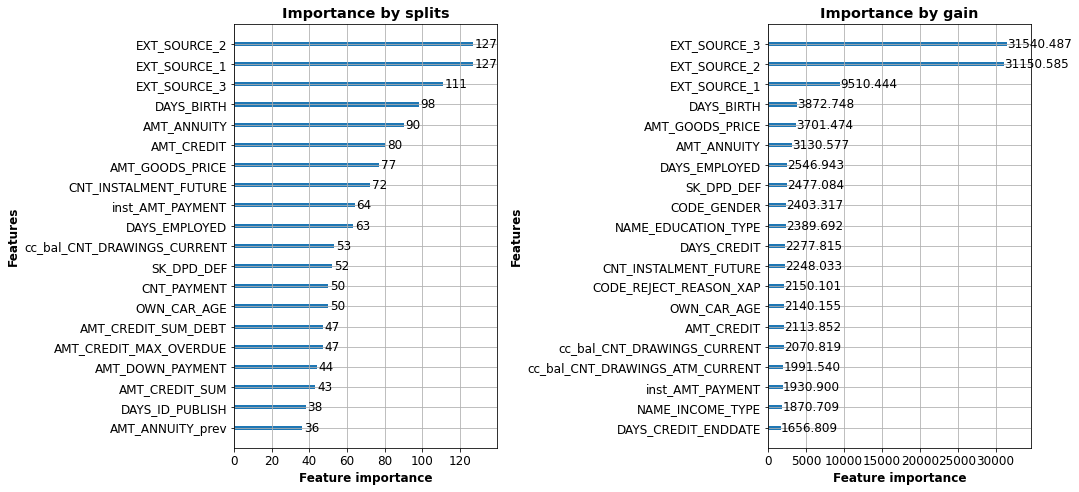

In [68]:
%%time
evals_result = {}
""" Predict on test set and create submission """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                  feval=eval_fonct,
                 num_boost_round=optimum_boost_rounds)
clf.params['objective'] = 'probability'
contrib = clf.predict(X_test, pred_contrib =True)
y_pred = clf.predict(X_test)
# out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
# out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')

In [69]:
# clf.params['objective'] = 'binary'
# clf.params['objective'] = 'probability'

# https://github.com/slundberg/shap/issues/1042
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


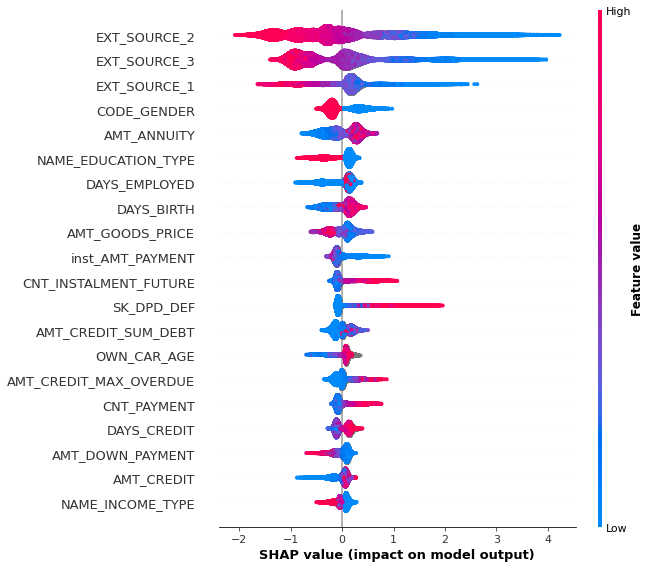

In [72]:
shap.summary_plot(shap_values, X_test)

In [73]:
len(shap_values)

101479

In [74]:
base = explainer.expected_value
base

-6.409900444600201

In [75]:
1/(1+np.exp(-base))

0.001642486082439956

In [76]:
np.log(y_test.sum()/(len(y_test)-y_test.sum()))

-2.442523782420533

In [77]:
type(np.array(X_test))

numpy.ndarray

In [78]:
df_homecredit[df_homecredit["Row"]=="AMT_ANNUITY"]

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN


In [79]:
df_application_train.loc[df_application_train["TARGET"]==1, "AMT_ANNUITY"].mean()

26481.744290030212

In [80]:
df_application_train.loc[df_application_train["TARGET"]==0, "AMT_ANNUITY"].mean()

27163.62334880463

In [81]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

infos sur l'utilisation de predict avec pred_contrib=True :  
https://github.com/microsoft/LightGBM/issues/1969

outil pour l'interprétation : SHAP  
https://github.com/slundberg/shap

In [82]:
y_pred.shape

(101479,)

In [83]:
contrib.shape

(101479, 375)

In [84]:
y_pred.mean()

0.15217669534131711

In [85]:
contrib[:,:-1].mean()

-5.778400585290717e-06

In [86]:
np.unique(contrib[:,-1])

array([-6.40990044])

In [87]:
contrib[:10,-1]

array([-6.40990044, -6.40990044, -6.40990044, -6.40990044, -6.40990044,
       -6.40990044, -6.40990044, -6.40990044, -6.40990044, -6.40990044])

In [88]:
np.min(contrib[:, :-1]) - np.max(contrib[:, :-1])

-6.3150479020039185

In [89]:
y_pred[:10]

array([0.3309797 , 0.10595153, 0.25721341, 0.05867429, 0.09742028,
       0.26043951, 0.0844374 , 0.22084796, 0.16701082, 0.10709775])

In [90]:
data.shape

(307511, 374)

## Calcul du seuil


Nous travaillons pour un organisme de crédit. Nous voulons donc minimiser le risque que le crédit ne soit pas remboursé. Nous voulons donc minimiser le nombre de faux négatifs, c'est à dire les personnes auxquelles on accorderait un crédit et qui ne seraient pas en mesure de le rembourser.    

Calculons le seuil correspondant à un taux de faux négatifs (FN/(FN+TP))choisi.  
Pour avoir un taux de faux négatifs < 5%, il faut un taux de vrai positifs (TP/(FN+TP))>95%.

In [91]:
if eval_fonct_str=="eval_auc":
    fpr, tpr, th = roc_curve(y_test, y_pred)
    fn_max = 0.05
    idx = np.min(np.where(tpr>(1-fn_max)))
#     print(f"Pour un taux de faux négatif de {fn_max*100}%, ")
#     print(f"le taux de faux positifs est de {fpr[idx]*100:.1f}%,")
#     print(f"et le seuil est de {th[idx]*100:.1f}%")
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str =="eval_average_precision":
    prec, rec, th = precision_recall_curve(y_test, y_pred)
    fn_max = 0.15
    idx = np.max(np.where(rec>(1-fn_max)))
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str in ["eval_Kulczynski_mod"]:
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_perso1":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1, eval_fonct_param2) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_tanimoto_mod":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "fbeta_eval3":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, to_labels(y_pred, t), eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
   

seuil :  0.1136740451561545
tp :  6900
tn :  47643
fp :  45719
fn :  1217
fpr = 48.97%
fnr = 14.99%
precision = 13.11%
recall = 85.01%


In [92]:
# pd.Series(y_pred).to_csv("y_pred_fbeta3_95.csv", index = False)

**fbeta_score, beta=4**  
tp :  7898  
tn :  16390  
fp :  76972  
fn :  219  
fpr = 82.44%  
fnr = 2.70%  
precision = 9.31%  
recall = 97.30%  

**fbeta_score, beta=3.8**  
seuil :  0.05  
score :  0.6207372298025252  
tp :  7602  
tn :  29084  
fp :  64278  
fn :  515  
fpr = 68.85%  
fnr = 6.34%  
precision = 10.58%  
recall = 93.66%  

**fbeta_score, beta=3.6**  
seuil :  0.06  
score :  0.6108316344692227  
tp :  7331  
tn :  38346  
fp :  55016  
fn :  786  
fpr = 58.93%  
fnr = 9.68%  
precision = 11.76%  
recall = 90.32%  

**fbeta_score, beta=3**   
tp :  6876  
tn :  48479  
fp :  44883  
fn :  1241  
fpr = 48.07%  
fnr = 15.29%  
precision = 13.28%  
recall = 84.71%  

**fbeta_score, beta=3, 1000 rounds**   
seuil :  0.07  
score :  0.557031555613509  
tp :  6835  
tn :  50546  
fp :  42816  
fn :  1282  
fpr = 45.86%  
fnr = 15.79%  
precision = 13.77%  
recall = 84.21%  

**fbeta_score, beta = 2**    
tp :  5502  
tn :  68102  
fp :  25260  
fn :  2615  
fpr = 27.06%  
fnr = 32.22%  
precision = 17.89%  
recall = 67.78%  

**AUC**    
tp : 7712  
tn : 27154  
fp : 66208  
fn : 405  
fpr : 0.7091536171033183  
fnr : 0.04989528150794629  
precision : 0.10432900432900433  
recall : 0.9501047184920537  


**average_precision**  
seuil :  0.07509545445933284  
tp :  7712  
tn :  25559  
fp :  67803  
fn :  405  
fpr = 72.62%  
fnr = 4.99%  
precision = 10.21%  
recall = 95.01%   

**balanced_accuracy_score**    
tp :  5374  
tn :  69599  
fp :  23763  
fn :  2743  
fpr = 25.45%  
fnr = 33.79%  
precision = 18.44%  
recall = 66.21%  

**Matthews**  
tp :  5146  
tn :  71592  
fp :  21770  
fn :  2971  
fpr = 23.32%  
fnr = 36.60%  
precision = 19.12%  
recall = 63.40%  

**tanimoto_mod**    
seuil :  0.41000000000000003  
score :  0.750621228257011  
tp :  1103  
tn :  91935  
fp :  1427  
fn :  7014  
fpr = 1.53%  
fnr = 86.41%  
precision = 43.60%  
recall = 13.59%  

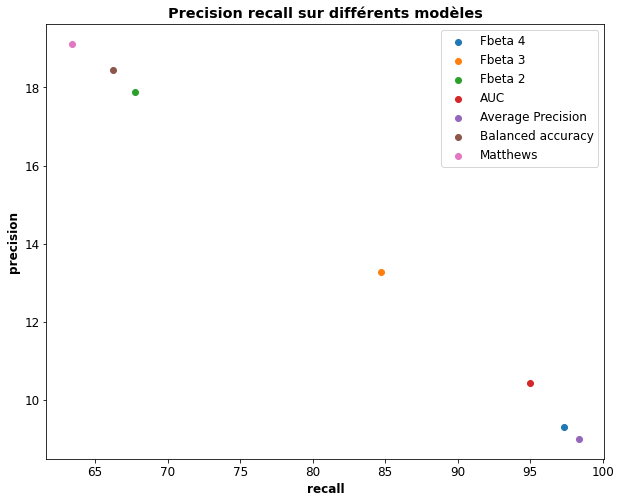

In [93]:
plt.scatter(y=9.31, x=97.3, label="Fbeta 4")
plt.scatter(y=13.28, x=84.71, label="Fbeta 3")
plt.scatter(y=17.89, x=67.78, label="Fbeta 2")
plt.scatter(y=10.43, x=95, label="AUC")
plt.scatter(y=9, x=98.36, label="Average Precision")
plt.scatter(y=18.44, x=66.21, label="Balanced accuracy")
plt.scatter(y=19.12, x=63.40, label="Matthews")
plt.legend()
plt.title("Precision recall sur différents modèles")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()


In [94]:
# prec, rec, th = precision_recall_curve(y_test, y_pred)
# plt.plot(rec, prec)
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.title("optimisation de Average Precision")
# plt.show()

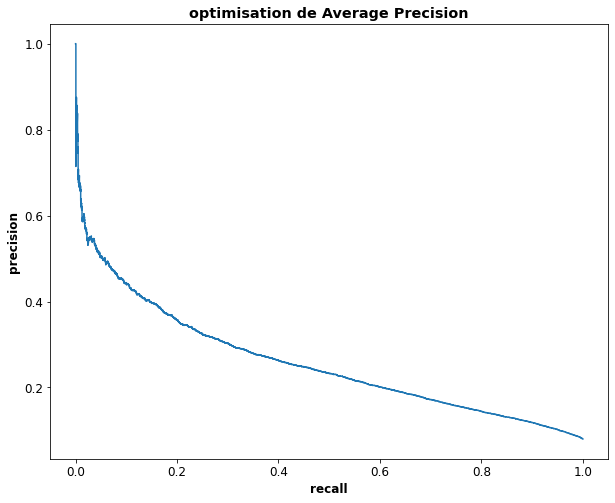

# Explicabilité

## Préparation des données

Nous reprenons le modèle qui a déjà été entraîné (sur le jeu d'entraînement) et nous l'utilisons maintenant pour prédire la totalité des données.  

In [95]:
y_pred = clf.predict(data)
contrib = clf.predict(data, pred_contrib =True)
y_pred

array([0.48350288, 0.05766326, 0.07030576, ..., 0.15960853, 0.10341132,
       0.14658324])

In [96]:
contrib[:, -1]

array([-6.40990044, -6.40990044, -6.40990044, ..., -6.40990044,
       -6.40990044, -6.40990044])

In [97]:
classe = (y_pred>=seuil).astype("int")
classe

array([1, 0, 0, ..., 1, 0, 1])

In [98]:
classe.sum()/len(classe)

0.5178578977662588

In [99]:
# fpr, tpr, th = roc_curve(y, y_pred[:,1])
# auc_test =  auc(fpr, tpr)
# auc_test

In [100]:
data_applicant = pd.concat([applicants, pd.Series(y_pred, name="score"), data], axis=1)
data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0.483503,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.057663,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0.070306,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.071798,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0.174881,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.253135,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0.217872,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0.159609,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,0.103411,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [101]:
feature_gain = pd.concat([pd.Series(clf.feature_name(), name="feature"),
    pd.Series(clf.feature_importance(importance_type='gain'), name="gain")], axis=1)
feature_gain.sort_values(by="gain", ascending=False).head(20)

,feature,gain
41,EXT_SOURCE_3,31540.486600
40,EXT_SOURCE_2,31150.584970
39,EXT_SOURCE_1,9510.444300
15,DAYS_BIRTH,3872.748036
8,AMT_GOODS_PRICE,3701.474392
7,AMT_ANNUITY,3130.576593
16,DAYS_EMPLOYED,2546.942902
331,SK_DPD_DEF,2477.084060
1,CODE_GENDER,2403.316939
11,NAME_EDUCATION_TYPE,2389.691816


In [102]:
(feature_gain["gain"]==0.).sum()

143

## Données pour l'explicabilité

In [160]:
# clf.params['objective'] = 'probability'
# https://github.com/slundberg/shap/issues/1042
explainer = shap.TreeExplainer(clf, feature_perturbation = "tree_path_dependent")
shap_values = explainer.shap_values(data)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [161]:
explainer.expected_value

-6.409900444600201

In [162]:
shap_values.shape

(307511, 374)

In [163]:
shap_values.sum()

-219.30848105892892

In [165]:
np.exp(explainer.expected_value)

0.0016451882812949761

In [166]:
odds = np.exp(-explainer.expected_value)
odds

607.8331649754218

expected_value (base value) est le logarithme de la cote (?? odds) de chaque classe. p(0)/p(1).  
Comme p(0) > p(1), p(0)/p(1) > 1 et ln(p(0)/p(1))>0.  
De même p(1)/p(0) < 1 et ln( p(1)/p(0 ) <0.

In [167]:
np.log(y_train.sum()/len(y_train))

-2.512143849896499

In [168]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [169]:
np.sum(contrib[:,:-1])

-219.30848105892892

In [170]:
np.log((y_train==1).sum()/(y_train==0).sum()*100)

2.177597999559703

In [171]:
y_pred.mean()

0.15231840903145114

## Analyse d'une demande

In [172]:
np.random.seed(42)

In [173]:
this_client = np.random.randint(0, len(y))
this_client

121958

### Description du client

In [174]:
no_client = data_applicant.loc[this_client, "SK_ID_CURR"]
print("numéro de client : ", no_client)
genre = data_applicant.loc[this_client, "CODE_GENDER"]
if genre==0:
    print("genre : masculin")
else :
    print("genre : féminin")
age_jours = data_applicant.loc[this_client, "DAYS_BIRTH"]
print(f"âge : {-age_jours/365:.0f} ans")

numéro de client :  241394
genre : masculin
âge : 36 ans


In [175]:
df_homecredit[df_homecredit["Row"]=="CNT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN


In [176]:
list(df_homecredit[df_homecredit["Row"]=="AMT_GOODS_PRICE"]["Description"])

['For consumer loans it is the price of the goods for which the loan is given',
 'Goods price of good that client asked for (if applicable) on the previous application']

In [177]:
# df_application_train["AMT_ANNUITY"].describe()
df_pos_cash_balance["CNT_INSTALMENT_FUTURE"].describe()

count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64

In [178]:
df_prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Score et interprétation

In [179]:
score = data_applicant.loc[this_client, "score"]
print("Score : " + f"{score*100:.1f} %")
if score < seuil :
    print("==> pas de risque particulier")
else :
    print("==> client à risque")
score_ext_1, score_ext_2, score_ext_3 = data_applicant.loc[this_client, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
print(f"Scores externes : score 1 : {score_ext_1*100:.0f}%, score 2 : {score_ext_2*100:.0f}%, score 3 : {score_ext_3*100:.0f}%")
annuity = data_applicant.loc[this_client, "AMT_ANNUITY"]
print(f"Montant de l'annuité : {annuity:.2f}")
goods_price = data_applicant.loc[this_client, "AMT_GOODS_PRICE"]
print(f"Prix du bien acheté : {goods_price}")
installment_prev_credit = data_applicant.loc[this_client, "CNT_INSTALMENT_FUTURE"]
print(f"Nombre de versements restants de précédents crédits : {installment_prev_credit}")

Score : 21.1 %
==> pas de risque particulier
Scores externes : score 1 : 35%, score 2 : 41%, score 3 : 28%
Montant de l'annuité : 35239.50
Prix du bien acheté : 630000.0
Nombre de versements restants de précédents crédits : 8.4


In [180]:
contrib[:,-1]

array([-6.40990044, -6.40990044, -6.40990044, ..., -6.40990044,
       -6.40990044, -6.40990044])

In [181]:
contrib[:,:-1].sum()

-219.30848105892892

In [182]:
np.where(data.columns=="CODE_GENDER")

(array([1], dtype=int64),)

In [183]:
y_train.mean()

0.08109419895938495

In [184]:
data.iloc[this_client,:]

NAME_CONTRACT_TYPE                0.0000
CODE_GENDER                       0.0000
FLAG_OWN_CAR                      1.0000
FLAG_OWN_REALTY                   0.0000
CNT_CHILDREN                      0.0000
                                 ...    
inst_NUM_INSTALMENT_NUMBER        2.5000
inst_DAYS_INSTALMENT           -786.0000
inst_DAYS_ENTRY_PAYMENT        -811.7500
inst_AMT_INSTALMENT           12803.1075
inst_AMT_PAYMENT              12803.1075
Name: 121958, Length: 374, dtype: float64

In [187]:
len(shap_values[this_client,:])

374

In [188]:
1/(1+np.exp(-0.081))

0.5202389355718147

In [189]:
p=0.081
np.log(p/(1-p))

-2.428836967683248

In [190]:
np.log(p)

-2.513306124309698

In [194]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:], link="logit")
# shap.force_plot(explainer.expected_value[1], shap_values[1][this_client,:], data.iloc[this_client,:], link="logit")
# shap.visualize(shap_values[this_client,:], data.iloc[this_client,:], link=shap.LogitLink())

In [ ]:
# https://www.kaggle.com/dansbecker/shap-values
# https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Comparaison à des clients semblables